## Data utilities
this file loads all datasets and contains helper functions for cleaning, validation, standarding cols and creating image grids

In [ ]:
# data & I/O
import os
import re
import sys
import json
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np

# dataset loading & handling
from datasets import load_dataset, Image as HFImage
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pandas.api.types import is_integer_dtype

# plotting
import matplotlib.pyplot as plt

# image handling
from PIL import Image as PILImage
from random import sample

# transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import softmax

### Helper functions
- `preprocess text` (sentiment analysis)
- `map_labels`
- `train_val_test_split`
- `save_df (I/O)`
- `load_df (I/O)`
- `quick_stats`
- `plot class counts`
- `show_image_grid`
- `standardise_columns`
- `load_sentiment_data`
- `load_model_and_tokenizer`
- `predict_sentiment_labels`
- `evaluate`

In [4]:
#remove URL and special characters
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = text.lower()
    return text

#save dtaframe to csv
def save_df(df: pd.DataFrame, path: str | Path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)

#load dataframe from csv
def load_df(path: str | Path) -> pd.DataFrame:
    return pd.read_csv(path)

def train_val_test_split(df: pd.DataFrame,
                         label_col: str,
                         test: float = 0.2,
                         val: float = 0.1,
                         seed: int = 42):
    train_df, temp_df = train_test_split(
        df, test_size=test+val, stratify=df[label_col], random_state=seed)
    val_size = val / (test + val)
    val_df, test_df = train_test_split(
        temp_df, test_size=val_size, stratify=temp_df[label_col], random_state=seed)
    return train_df, val_df, test_df

#  Create a mapping dictionary for labels
def map_labels(df: pd.DataFrame, col: str, mapping: dict) -> pd.DataFrame:
    df[col] = df[col].map(mapping)
    return df

#  Quick stats 
def show_basic_stats(df: pd.DataFrame):
    print("Rows:", len(df))
    print("Columns:", list(df.columns))
    print("First 3 rows:\n", df.head(3))
    for col in df.select_dtypes(include='object').columns:
        print(f"Unique values in '{col}':", df[col].nunique())

#  Plot class counts
def plot_class_counts(df: pd.DataFrame, label_col: str):
    df[label_col].value_counts().sort_index().plot(kind="bar")
    plt.title("Class distribution")
    plt.xlabel(label_col)
    plt.ylabel("Count")
    plt.show()

#  Image grid 
def show_image_grid(df: pd.DataFrame, path_col: str, n: int = 6):
    paths = sample(df[path_col].tolist(), n)
    fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
    for ax, p in zip(axes, paths):
        ax.imshow(PILImage.open(p))
        ax.axis("off")
    plt.show()

#  Column normaliser 
def standardise_columns(df: pd.DataFrame, rename_dict: dict) -> pd.DataFrame:
    return df.rename(columns=rename_dict)

def load_sentiment_data(csv_path: str, text_col: str = "text", label_col: str = "label"):
    df = pd.read_csv(csv_path)
    return df[text_col].tolist(), df[label_col].tolist()


def load_model_and_tokenizer(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.eval()
    return model, tokenizer


def predict_sentiment_labels(model, tokenizer, texts):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = softmax(logits, dim=1)
            pred = torch.argmax(probs).item()
            predictions.append(pred)
    return predictions

# Evaluate and save results
def evaluate(model_name, y_true, y_pred, output_json):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    results = {
        "model": model_name,
        "task": "sentiment",
        "metrics": {
            "accuracy": round(acc, 4),
            "f1": round(f1, 4)
        },
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, "w") as f:
        json.dump(results, f, indent=2)

    print("Evaluation complete")
    print(json.dumps(results, indent=2))
    return results

## load all datasets into seperate dataframes

In [11]:
def load_cifar10_df(root_dir: str | Path = "cifar10_images",
                    split: str = "train",
                    save_png: bool = True) -> pd.DataFrame:
    """
     returns a DataFrame with columns:  image_path | label
    """
    cifar = load_dataset("cifar10", split=split)        
    cifar = cifar.cast_column("img", HFImage(decode=True))  

    paths, labels = [], []
    out_dir = Path(root_dir) / split
    out_dir.mkdir(parents=True, exist_ok=True)

    for i, row in tqdm(enumerate(cifar), total=len(cifar), desc="Saving PNGs"):
        if save_png:
            file_path = out_dir / f"{i:05d}.png"
            row["img"].save(file_path)
        else:                                            
            file_path = Path(row["img"].filename)
        paths.append(file_path.as_posix())
        labels.append(row["label"])

    return pd.DataFrame({"image_path": paths, "label": labels})

In [6]:
def load_humaneval_df() -> pd.DataFrame:
    """
    Returns a DataFrame with columns:  task_id | prompt | canonical_solution | test
    """
    he = load_dataset("openai_humaneval", split="test")
    return he.to_pandas()[["task_id", "prompt", "canonical_solution", "test"]]

In [7]:
#load sentiment analysis, text summarization datasets into dataframes
sentiment_df = pd.read_csv("e:/ML/datasets/sentiment-analysis-dataset/versions/9/test.csv", delimiter=",", encoding="latin1")
textSummarization_df = pd.read_csv(r"datasets\samsum-dataset-text-summarization\versions\1\samsum-test.csv", delimiter=",", encoding="latin1")

## exploration of each dataset loaded:


Saving PNGs: 100%|██████████| 50000/50000 [00:42<00:00, 1171.02it/s]


Loaded CIFAR‑10 ➜ 50000 rows
 first image exists at cifar10_images/train/00000.png
dataFrame is valid, labels are integers 0-9
Rows: 50000
Columns: ['image_path', 'label']
First 3 rows:
                        image_path  label
0  cifar10_images/train/00000.png      0
1  cifar10_images/train/00001.png      6
2  cifar10_images/train/00002.png      0
Unique values in 'image_path': 50000


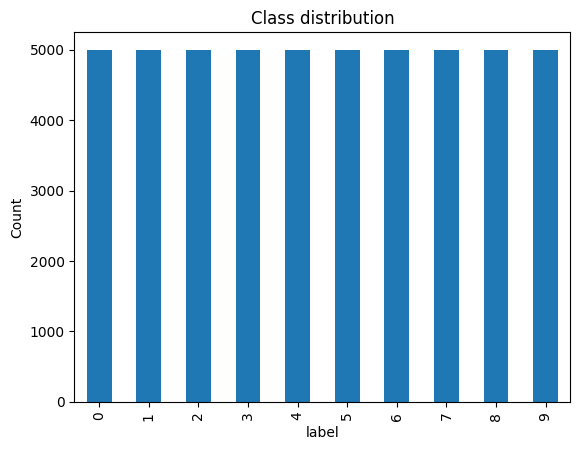

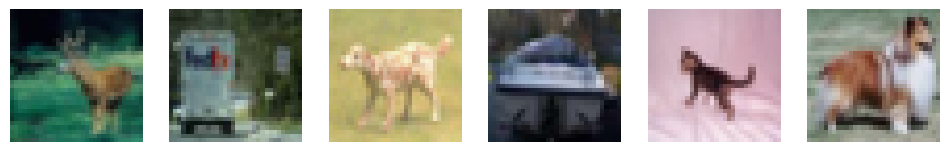

In [13]:
cifar_df = load_cifar10_df(split="train")   
print("Loaded CIFAR‑10 ➜", len(cifar_df), "rows")

#debgging
first_path = cifar_df.loc[0, "image_path"]
assert os.path.exists(first_path), f"File missing: {first_path}"
assert "label" in cifar_df.columns
assert is_integer_dtype(cifar_df["label"]), "Labels are not integer dtype"
assert cifar_df["label"].between(0, 9).all(), "Labels outside 0‑9"
print(" first image exists at", first_path)
print("dataFrame is valid, labels are integers 0-9")

# 3. Basic stats & class counts 
show_basic_stats(cifar_df)
plot_class_counts(cifar_df, "label")
show_image_grid(cifar_df, "image_path", n=6)


Loaded 8092 images with captions.


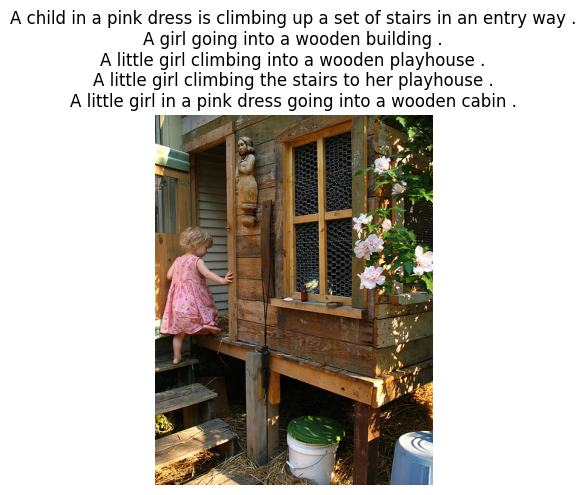

In [ ]:


#  load Captions 
def load_captions(filepath):
    captions_dict = {}
    with open(filepath, 'r') as f:
        for line in f:
            img_id, caption = line.strip().split('\t')
            img_id = img_id.split('#')[0]
            if img_id not in captions_dict:
                captions_dict[img_id] = []
            captions_dict[img_id].append(caption)
    return captions_dict

captions_path = 'datasets/captioning/captioning_text/Flickr8k.token.txt'
captions = load_captions(captions_path)
print(f"Loaded {len(captions)} images with captions")

# sample iamge and captions
sample_id = list(captions.keys())[0]
img_path = os.path.join('datasets/captioning/captioning_dataset/Flicker8k_Dataset', sample_id)
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title('\n'.join(captions[sample_id]))
plt.show()


In [ ]:
#sentiment analysis dataset exploration
sentiment_df.info()
sentiment_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


(4815, 9)

In [ ]:
#text summarization dataset exploration
textSummarization_df.info()
textSummarization_df.shape
textSummarization_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        819 non-null    object
 1   dialogue  819 non-null    object
 2   summary   819 non-null    object
dtypes: object(3)
memory usage: 19.3+ KB


(819, 3)

### explore / prepare the sentiment analysis data (preprocessing)

In [ ]:

TEXTS = sentiment_df["text"].tolist()
LABELS = sentiment_df["sentiment"].tolist()
# Map sentiment labels to integers
SENTIMENT_MAP = {"negative": 0, "neutral": 1, "positive": 2}
LABELS = [SENTIMENT_MAP[label.lower()] for label in LABELS if isinstance(label, str)]

# sample
print("Mapped labels:", LABELS[:5])


Mapped LABELS: [1, 2, 0, 2, 2]
